# Generate Small Train

In [19]:
import os 
import shutil
PATH = './ILSVRC2012'
ori_dir = os.path.join(PATH, 'full_train')
copy_dir = os.path.join(PATH, 'train')
os.makedirs(copy_dir, exist_ok=True)

for file_name in os.listdir(ori_dir):
    cur_dir = os.path.join(ori_dir, file_name)
    copy_cur_dir = os.path.join(copy_dir, file_name)
    os.makedirs(copy_cur_dir, exist_ok=True)

    for img in os.listdir(cur_dir)[:100]:
        cur_img = os.path.join(cur_dir, img)
        copy_img = os.path.join(copy_cur_dir, img)
        shutil.copy(cur_img, copy_img)
    print(file_name)

n01440764
n01443537
n01484850
n01491361
n01494475
n01496331
n01498041
n01514668
n01514859
n01518878
n01530575
n01531178
n01532829
n01534433
n01537544
n01558993
n01560419
n01580077
n01582220
n01592084
n01601694
n01608432
n01614925
n01616318
n01622779
n01629819
n01630670
n01631663
n01632458
n01632777
n01641577
n01644373
n01644900
n01664065
n01665541
n01667114
n01667778
n01669191
n01675722
n01677366
n01682714
n01685808
n01687978
n01688243
n01689811
n01692333
n01693334
n01694178
n01695060
n01697457
n01698640
n01704323
n01728572
n01728920
n01729322
n01729977
n01734418
n01735189
n01737021
n01739381
n01740131
n01742172
n01744401
n01748264
n01749939
n01751748
n01753488
n01755581
n01756291
n01768244
n01770081
n01770393
n01773157
n01773549
n01773797
n01774384
n01774750
n01775062
n01776313
n01784675
n01795545
n01796340
n01797886
n01798484
n01806143
n01806567
n01807496
n01817953
n01818515
n01819313
n01820546
n01824575
n01828970
n01829413
n01833805
n01843065
n01843383
n01847000
n01855032
n01855672


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Explanation-for-class-logits" data-toc-modified-id="Explanation-for-class-logits-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Explanation for class logits</a></span><ul class="toc-item"><li><span><a href="#Additional-logit-explanations" data-toc-modified-id="Additional-logit-explanations-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Additional logit explanations</a></span></li><li><span><a href="#Comparison-to-post-hoc" data-toc-modified-id="Comparison-to-post-hoc-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Comparison to post-hoc</a></span></li><li><span><a href="#Ambiguous-examples" data-toc-modified-id="Ambiguous-examples-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Ambiguous examples</a></span></li></ul></li><li><span><a href="#Visualise-intermediate-neurons" data-toc-modified-id="Visualise-intermediate-neurons-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Visualise intermediate neurons</a></span></li><li><span><a href="#CIFAR10-—-B-ablation" data-toc-modified-id="CIFAR10-—-B-ablation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>CIFAR10 — B-ablation</a></span></li></ul></div>

In [84]:
%matplotlib inline


%load_ext autoreload
%autoreload 2


!git pull

#!pip install latex




import numpy as np
from experiments.Imagenet.bcos.model import get_model
from experiments.Imagenet.bcos.experiment_parameters import exps
from data.data_handler import Data
from data.data_transforms import AddInverse
from interpretability.utils import grad_to_img, explanation_mode
from torch.autograd import Variable
from project_utils import to_numpy, to_numpy_img
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
import os
import json
import torch
from data.imagenet_classnames import name_map
sns.set_style("white")


from torch.hub import download_url_to_file

from project_utils import get_precomputed_results
get_precomputed_results()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
hint: Pulling without specifying how to reconcile divergent branches is
hint: discouraged. You can squelch this message by running one of the following
hint: commands sometime before your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.
Already up to date.


# Teacher Model

In [85]:
exp_params = exps["densenet_121_cossched"]
data = Data("Imagenet", only_test_loader=True, **exp_params)
data_loader = data.get_test_loader()
teacher_model = get_model(exp_params).cuda()

../
bcos_pretrained/densenet_121_cossched
bcos_pretrained/densenet_121_cossched/state_dict.pkl


# Student Model

In [86]:
student_exp_params = exps["my_densenet_121_cossched"]

student_model = get_model(student_exp_params).cuda()

bcos_pretrained/my_densenet_121_cossched
bcos_pretrained/my_densenet_121_cossched/state_dict.pkl


KeyError: 'model_url'

In [ ]:
for name, param in list(student_model.named_children()):
    print(name,param,sep="   ")

#MyAdaptiveAvgPool2d = list(model.named_children())[1][1]
#FinalLayer = list(model.named_children())[2][1]

0   DenseNet(
  (features): Sequential(
    (conv0): BcosConv2d(
      (linear): NormedConv2d(6, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    )
    (pool0): AvgPool2d(kernel_size=3, stride=2, padding=1)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (conv1): BcosConv2d(
          (linear): NormedConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (conv2): BcosConv2d(
          (linear): NormedConv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (conv1): BcosConv2d(
          (linear): NormedConv2d(96, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (conv2): BcosConv2d(
          (linear): NormedConv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (denselayer3): _DenseLayer(
        (conv1): BcosConv2d(
          (linear): NormedConv2d(128, 256, kern

# Generate Datasets

In [ ]:
'''
import os 
import cv2
import pandas as pd

#exp_params = exps["densenet_121_cossched"]
exp_params = exps["my_densenet_121_cossched"]
data = Data("Imagenet", only_test_loader=False, **exp_params)
print(exp_params)
model = get_model(exp_params).cuda()

for type in ['test', 'train']:
    print(type)

    if type == 'train':
        data_loader = data.get_train_loader()
    else:
        data_loader = data.get_test_loader()

    PATH = os.getcwd()
    dataset_path = os.path.join(PATH, 'my_dataset')
    dir_path = os.path.join(dataset_path, type)

    os.makedirs(dir_path, exist_ok=True)

    explanation_mode(model, True)

    columns = ['label', 'ori_img', 'weight_img']
    df = pd.DataFrame(columns=columns)

    for num, item in enumerate(data_loader.dataset):
        if num % 10000 == 0:
            print('{}/{} 진행중...'.format(num, len(data_loader.dataset)))
        img = item[0][None].cuda()
        label = item[1][None].cuda()

        label = [idx for idx, item in enumerate(label[0]) if item > 0][0]
        
        _img = Variable(AddInverse()(img), requires_grad=True)  

        top2, c_idcs = model(_img)[0].topk(2)
        _img.grad = None
        top2[0].backward(retain_graph=True)
        w1 = _img.grad
        _img.grad = None
        top2[1].backward()
        w2 = _img.grad

        ori_img = to_numpy_img(img[0])
        ori_img = ori_img*255
        ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
        w_img = grad_to_img(_img[0], w1[0])
        w_img = w_img*255
        w_img = cv2.cvtColor(w_img, cv2.COLOR_BGRA2RGBA) # alpha가 사라짐

        ori_img_path = os.path.join(dir_path, 'ImageNet_{}.png'.format(num))
        w_img_path = os.path.join(dir_path, 'ImageNet_weight_{}.png'.format(num))

        cv2.imwrite(ori_img_path, ori_img)
        cv2.imwrite(w_img_path, w_img)

        temp = pd.DataFrame([[label, ori_img_path, w_img_path]], columns=columns)

        df = pd.concat([df, temp])
    df.to_csv(os.path.join(dataset_path, '{}_data.csv'.format(type)), index=False)
'''

/root/ReverseEngineering
/root/ReverseEngineering
test
0/50000 진행중...
10000/50000 진행중...
20000/50000 진행중...
30000/50000 진행중...
40000/50000 진행중...
train
0/1281167 진행중...
10000/1281167 진행중...
20000/1281167 진행중...
30000/1281167 진행중...
40000/1281167 진행중...
50000/1281167 진행중...
60000/1281167 진행중...
70000/1281167 진행중...
80000/1281167 진행중...


KeyboardInterrupt: 

# Explanation for class logits_Student_Model

# Explanation with NeuRes

In [175]:
%matplotlib inline


%load_ext autoreload
%autoreload 2


!git pull

#!pip install latex




import numpy as np
from experiments.Imagenet.bcos.model import get_model
from experiments.Imagenet.bcos.experiment_parameters import exps
from data.data_handler import Data
from data.data_transforms import AddInverse
from interpretability.utils import grad_to_img, explanation_mode
from torch.autograd import Variable
from project_utils import to_numpy, to_numpy_img
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
import os
import json
import torch
from data.imagenet_classnames import name_map
sns.set_style("white")


from torch.hub import download_url_to_file

from project_utils import get_precomputed_results
get_precomputed_results()

exp_params = exps["densenet_121_cossched"]
data = Data("Imagenet", only_test_loader=True, **exp_params)
data_loader = data.get_test_loader()
teacher_model = get_model(exp_params).cuda()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
hint: Pulling without specifying how to reconcile divergent branches is
hint: discouraged. You can squelch this message by running one of the following
hint: commands sometime before your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.
Already up to date.
../
bcos_pretrained/densenet_121_cossched
bcos_pretrained/densenet_121_cossched/state_dict.pkl


bcos_pretrained/densenet_121_cossched
bcos_pretrained/densenet_121_cossched/state_dict.pkl
torch.return_types.topk(
values=tensor([10.6974], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([20], device='cuda:0'))
torch.Size([3, 224, 224])
torch.Size([6, 224, 224])
torch.Size([6, 224, 224])
(4, 224, 224)
(4, 224, 224)


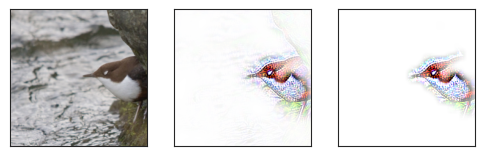

In [193]:
def move_and_scale(img, activation_func, temp=20):
    img_move = img - img.mean()
    img_scale = img_move / (temp * (img.max() - img.min()))
    img_filtered = activation_func(img_scale)
    return img_filtered - 0.001

teacher_model = get_model(exp_params).cuda()

neures = False

RELU = torch.nn.ReLU()
img = data_loader.dataset[1000][0][None].cuda()
_img = Variable(AddInverse()(img), requires_grad=True) 
explanation_mode(teacher_model, True) 

# Top 2 predictions
top, c_idcs = teacher_model(_img)[0].topk(1)

_img.grad = None
top.backward(retain_graph=True)
w1 = _img.grad.clone().detach()[0]
w2 = move_and_scale(w1, RELU)

#w2 = RELU(w1)
sns.set_style("white")
#for logit, c_idx, w in zip(top2, c_idcs, [w1[0], w2[0]]):
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 3))
# The 'positive evidence' is derived from those locations that have a net positive contribution
# to the respective output, according to the linear transformation matrix W_{1->L}
#fig.suptitle(f"Positive evidence for {name_map[c_idx.item()].split(',')[0]}", fontsize=18)
print(img[0].shape)
print(_img[0].shape)
print(w1.shape)
ax1.imshow(to_numpy_img(img[0]))
# Decoding the linear transform w based on the angles of the color channels.
# Only showing positively contributing pixels.
ax2.imshow(grad_to_img(_img[0], w1))
ax3.imshow(grad_to_img(_img[0], w2))
for ax in [ax1, ax2, ax3]:
    ax.set_xticks([])
    ax.set_yticks([])


In [191]:
import torch.nn.functional as F
smooth = 15
alpha_percentile = 99.5


# shape of img and linmap is [C, H, W], summing over first dimension gives the contribution map per location
contribs = (_img[0] * w1).sum(0, keepdim=True)
contribs = contribs[0]
alpha = (w1.norm(p=2, dim=0, keepdim=True))
alpha = torch.where(contribs[None] < 0, torch.zeros_like(alpha) + 1e-12, alpha)
if smooth:
        alpha = F.avg_pool2d(alpha, smooth, stride=1, padding=(smooth-1)//2)
alpha = (alpha / np.percentile(to_numpy(alpha), alpha_percentile)).clip(0, 1)
print(alpha.shape)

torch.Size([1, 224, 224])


# Explanation for class logits

In [13]:
img = data_loader.dataset[50*14 + 4][0][None].cuda()
print("Image shape: ", img.shape)
#print(data_loader.dataset[0][0][None].shape)
#print(data_loader.dataset[0][1][None].shape)

Image shape:  torch.Size([1, 3, 224, 224])


The B-cos networks are trained with images encoded as 
$$\text{pixel} = [r, g, b, 1-r, 1-g, 1-b],$$
see Section 4 in the paper. As such, the images have 6 color channels.

In [14]:
_img = Variable(AddInverse()(img), requires_grad=True)  
print("Image shape: ", _img.shape)

Image shape:  torch.Size([1, 6, 224, 224])


In order to compute the dynamic linear transforms $\mathbf W_{1\rightarrow L}(\mathbf x)$
we detach the dynamically computed linear transforms from the computational graph in the forward pass in each layer.
This allows to calculate $\mathbf W_{1\rightarrow L}(\mathbf x)$ with a simple out.backward() call.

In [15]:
# Setting detaching to True
explanation_mode(model, True)

In the following, we compute the top 2 predictions of the model for the chosen image and visualise the corresponding matrix rows.

In [7]:
# Top 2 predictions
top2, c_idcs = model(_img)[0].topk(2)

In [9]:
# Compute w_1:
_img.grad = None
top2[0].backward(retain_graph=True)
w1 = _img.grad
_img.grad = None
top2[1].backward()
w2 = _img.grad


Note that the model computations are (up to numerical errors) _exactly_ summarised by the linear transforms:

In [10]:
print(f"Full model output: y_1 = {top2[0]:.3f} | linear summary:  w_1 * x + b = {(_img*w1).sum() + model[-1].bias:.3f}")
print(f"Full model output: y_2 = {top2[1]:.3f} | linear summary:  w_2 * x + b = {(_img*w2).sum() + model[-1].bias:.3f}")

Full model output: y_1 = -0.302 | linear summary:  w_1 * x + b = -0.301
Full model output: y_2 = -0.882 | linear summary:  w_2 * x + b = -0.881


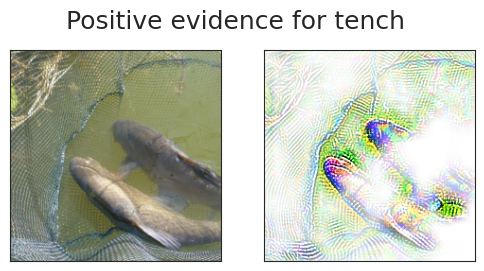

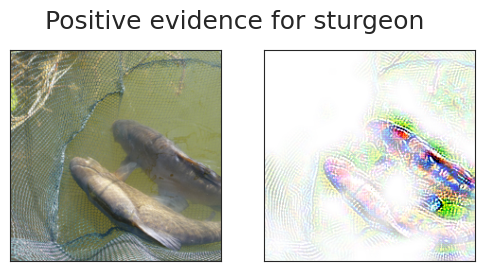

In [29]:
sns.set_style("white")
for logit, c_idx, w in zip(top2, c_idcs, [w1[0], w2[0]]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    # The 'positive evidence' is derived from those locations that have a net positive contribution
    # to the respective output, according to the linear transformation matrix W_{1->L}
    fig.suptitle(f"Positive evidence for {name_map[c_idx.item()].split(',')[0]}", fontsize=18)
    ax1.imshow(to_numpy_img(img[0]))
    # Decoding the linear transform w based on the angles of the color channels.
    # Only showing positively contributing pixels.
    ax2.imshow(grad_to_img(_img[0], w))
    for ax in [ax1, ax2]:
        ax.set_xticks([])
        ax.set_yticks([])


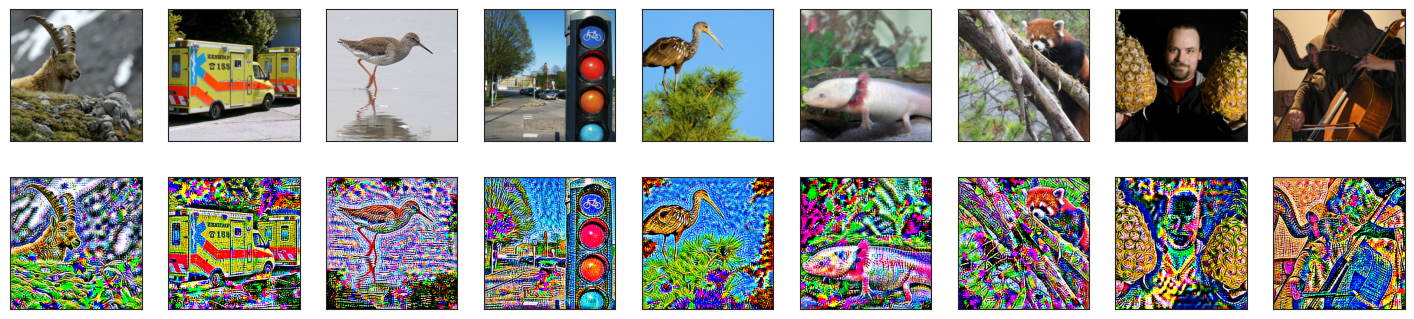

In [14]:
# Images shown in Fig. 1 in the paper
imgs = [17532, 20381, 7075, 46001, 6796, 1484, 19393, 47687, 29748]
fig, (img_axes, w_axes) = plt.subplots(2, len(imgs), figsize=(len(imgs)*2, 4))

for ax in img_axes:
    ax.set_xticks([])
    ax.set_yticks([])

for ax in w_axes:
    ax.set_xticks([])
    ax.set_yticks([])

    explanation_mode(model, True)
for ax_idx, img_idx in enumerate(imgs):
    model.zero_grad()
    img = data_loader.dataset[img_idx][0][None].cuda()    
    _img = Variable(AddInverse()(img), requires_grad=True)  
    model(_img)[0, img_idx//50].backward()
    w = _img.grad[0]
    img_axes[ax_idx].imshow(to_numpy_img(img[0]))
    w_axes[ax_idx].imshow(grad_to_img(_img[0], w))
    
fig.savefig("docs/media/example_figure.png")
    

## Additional logit explanations

In [15]:
!git pull

hint: Pulling without specifying how to reconcile divergent branches is
hint: discouraged. You can squelch this message by running one of the following
hint: commands sometime before your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.
Already up to date.


In [16]:
from interpretability.visualise_neurons import visualise_class_explanations

In [17]:
# Logits only precomputed for densenet_121_cossched
exp_params = exps["densenet_121_cossched"]
data = Data("Imagenet", only_test_loader=True, **exp_params)
data_loader = data.get_test_loader()
model = get_model(exp_params).cuda()
explanation_mode(model)

/root/ReverseEngineering


In [18]:
num_classes = 2
imgs_per_class = 3
logits = torch.from_numpy(np.loadtxt(f"results/{exp_params['exp_name']}/logits.np"))
max_vals, offset = torch.topk((logits.max(axis=1)[0].reshape(-1, 50)), imgs_per_class, axis=1)
sorted_classes = torch.argsort(max_vals.sum(1), descending=True).numpy()[:max(num_classes, 20)]


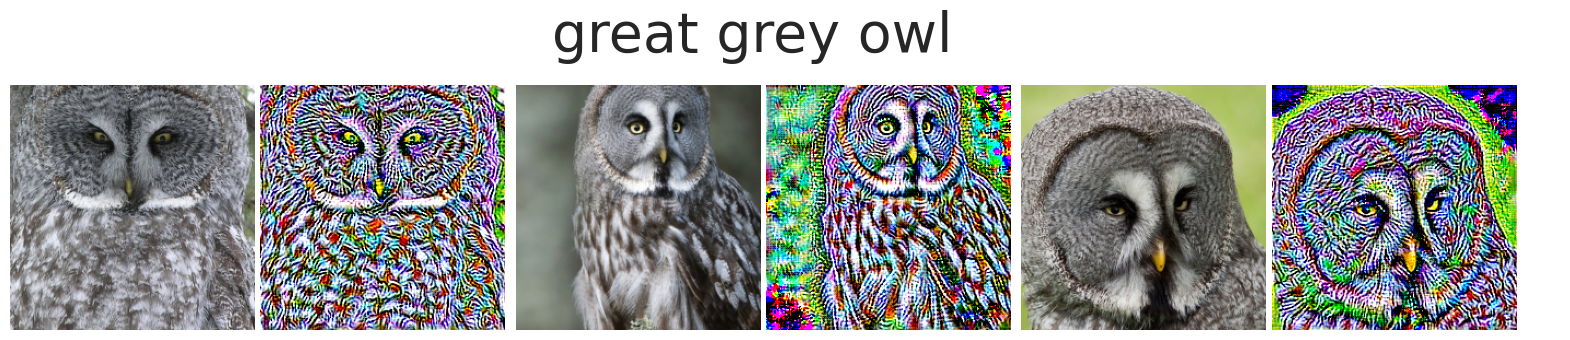

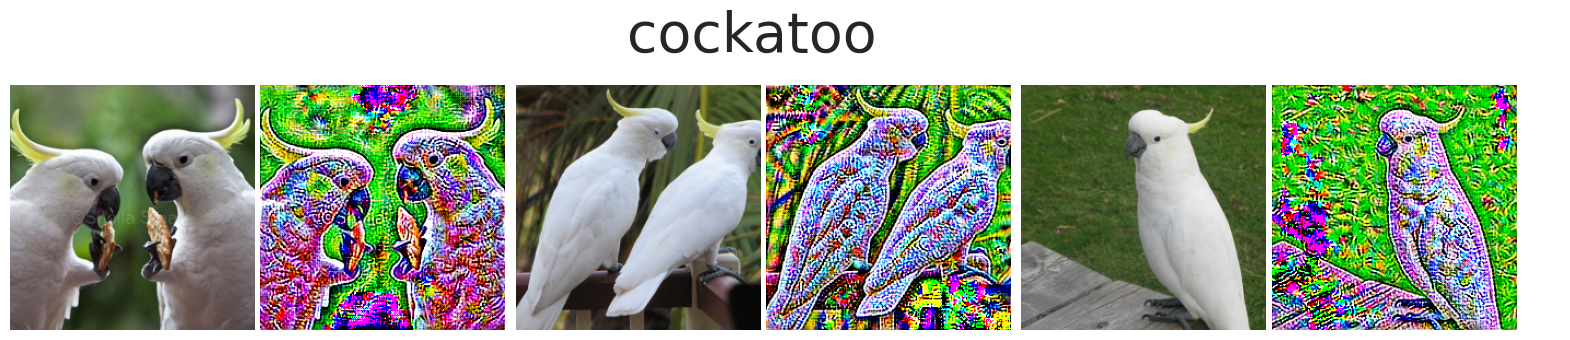

In [19]:
sns.set_style("white")

for class_idx in sorted_classes[:num_classes]:
    visualise_class_explanations(model, class_idx, offset[class_idx], data_loader)

## Comparison to post-hoc

In [20]:
from torch import nn

In [21]:
!git pull

hint: Pulling without specifying how to reconcile divergent branches is
hint: discouraged. You can squelch this message by running one of the following
hint: commands sometime before your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.
Already up to date.


In [22]:
from interpretability.explanation_methods.explainers.captum import IxG, IntGrad, DeepLIFT, GradCam
from interpretability.explanation_methods.explainers.rise import RISE
from interpretability.explanation_methods.explainers.lime import Lime



In [23]:
class Trainer:
    
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def predict(self, x):
        return self.model(AddInverse()(x)).sigmoid()
    
    def __call__(self, x):
        return self.model(AddInverse()(x))
    

In [24]:
selected_imgs = [(50*c_idx + offset[c_idx][0]).item() for c_idx in sorted_classes[:15]]

In [25]:
# num_ims = 100
explanation_mode(model, False)
trainer = Trainer(model)
gcam_expl = GradCam(trainer)
lime_expl = Lime(trainer, kernel_size=4, batch_size=32, num_samples=500)
ixg_expl = IxG(trainer)
intG_expl = IntGrad(trainer, internal_batch_size=64)
lift_expl = DeepLIFT(trainer)
rise_expl = RISE(trainer, batch_size=64, n=1500, s=8, p=.1)
pairs = [("GCam", gcam_expl), ("LIME", lime_expl),# ("IxG", ixg_expl), 
         ("IntG", intG_expl),
         ("DeepLIFT", lift_expl), ("RISE", rise_expl), 
        ]

img_tgt_pairs = [data_loader.dataset[im_idx] for im_idx in selected_imgs[::]]
atts = {
    name: [(to_numpy(expl.attribute((img[None]).cuda(), tgt.argmax())),
              print(f"\r{name}: {idx+1}/{len(selected_imgs)}", end="" if idx+1 != len(selected_imgs) else "\n"))[0]
             for idx, (img, tgt) in enumerate(img_tgt_pairs)]
    for name, expl in pairs
       }

GCam: 15/15


KeyboardInterrupt: 

In [ ]:
our_atts = []
explanation_mode(model, True)

for im_idx in selected_imgs[::]:
    img, tgt = data_loader.dataset[im_idx]
    _img = Variable(AddInverse()(img[None]).cuda(), requires_grad=True)
    model.zero_grad()
    out = model(_img)[0, tgt.argmax()]
    out.backward()
    our_atts.append(grad_to_img(_img[0], _img.grad.data[0]))
atts.update({"Ours": our_atts})

In [ ]:
sns.set_style("white")
# selected_imgs = np.arange(num_ims)
num_methods = len(atts)

for count, sel_ims in enumerate(np.array(selected_imgs).reshape(-1, 5)[:3]):

    fig, ax = plt.subplots(1, figsize=(len(sel_ims)*4, (num_methods+1)*4))

    for ax_idx1, im_idx in enumerate(sel_ims):
        running_idx = ax_idx1 + 5 * count
        att_idx = count * 5 + ax_idx1
        img, tgt = img_tgt_pairs[ax_idx1+5*count]
        ax.imshow(to_numpy_img(img), extent=(224*ax_idx1, 224*(ax_idx1+1), 0, 224))
        for ax_idx2, att_name in enumerate(["Ours", "GCam", "LIME", "IntG", "DeepLIFT", "RISE"]):
            if att_name not in  ["Ours", "LIME", "RISE"]:
                exp = atts[att_name][att_idx][0].sum(0)
                vrange = np.percentile(exp, 99.5)
                ax.imshow(exp.clip(0), vmin=-vrange, vmax=vrange,
                          cmap="bwr",
                         extent=(224*ax_idx1, 224*(ax_idx1+1), -(1+ax_idx2) * 224, -(ax_idx2) * 224))
            elif att_name == "LIME":
                cutout = to_numpy_img(torch.tensor(atts[att_name][att_idx][0]) * img)
                cutout = np.concatenate([cutout, atts[att_name][att_idx][0][0][..., None]], axis=-1)
                ax.imshow(cutout, extent=(224*ax_idx1, 224*(ax_idx1+1), -(1+ax_idx2) * 224, -(ax_idx2) * 224))
            elif att_name == "RISE":
                exp = atts[att_name][att_idx][0].sum(0)
#                 vrange = np.percentile(exp, 99.5)
                ax.imshow(exp.clip(0), vmin=exp.min(), vmax=exp.max(),
                          cmap="jet",
                         extent=(224*ax_idx1, 224*(ax_idx1+1), -(1+ax_idx2) * 224, -(ax_idx2) * 224))
            else:
                ax.imshow(atts[att_name][att_idx],
                         extent=(224*ax_idx1, 224*(ax_idx1+1), -(1+ax_idx2) * 224, -(ax_idx2) * 224))
            if not ax_idx1:
                plt.figtext(-30, -112 * (1+2*ax_idx2), f"{att_name}", transform=ax.transData, fontsize=40,
                            rotation=90, ha="center", va="center")
    plt.figtext(-30, 112, "Input image", transform=ax.transData, fontsize=40,
                            rotation=90, ha="center", va="center")
    ax.set_ylim(-3-224 * (num_methods), 224+3)
    ax.set_xlim(0-3, len(sel_ims)*224+3)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.hlines([224-224 * i for i in range(0, num_methods+2)], 0, 224*len(selected_imgs))
    ax.vlines([224*i for i in range(len(selected_imgs)+1)], -224*num_methods, 224)
    fig.savefig("docs/media/comparisons.png")
    break

## Ambiguous examples

In [ ]:
!git pull

In [ ]:
from interpretability.visualise_neurons import plot_top2_comparison

In [ ]:
sns.set_style("white")
explanation_mode(model, True)
for im_idx in [22359, 49203, 45644, 11701, 37044]:

    plot_top2_comparison(model, im_idx, data_loader)


# Visualise intermediate neurons

In [ ]:
from interpretability.visualise_neurons import visualise_intermediate_neuron_large, visualise_intermediate_neuron_grid


In [ ]:
# Make sure the model is in explanation mode


In [ ]:
neurons = [739, 797, 843, 823, 938, 473, 341]

In [ ]:
exp_params = exps["densenet_121_cossched"]
data = Data("Imagenet", only_test_loader=True, **exp_params)
data_loader = data.get_test_loader()
model = get_model(exp_params).cuda()
explanation_mode(model, True)

layer_idx = 7  # Relative layer index in the sequential model (from 1-10)
partial_model = model[0].get_sequential_model()[:model[0].get_layer_idx(layer_idx)]

with open(f"results/{exp_params['exp_name']}/feature_layer_{layer_idx}.json", "r") as file:
    sorted_activations = json.load(file, object_hook=lambda x: {int(k): v for k, v in x.items()})
sorted_neurons = np.loadtxt(f"results/{exp_params['exp_name']}/feature_layer_{layer_idx}_neurons_sorted.txt")
explanation_mode(model, True)


In [ ]:
# Alternatively, use ... in sorted_neurons[:N] to visualise the (on average) most active neurons
for neuron in neurons:  
    visualise_intermediate_neuron_large(int(neuron), sorted_activations, partial_model, data);

In [ ]:
visualise_intermediate_neuron_grid(partial_model, data, neuron_idx=473, layer_idx=layer_idx, 
                                   sorted_activations=sorted_activations,
                                   cols=7, rows=4, scaling=2)

# CIFAR10 — B-ablation

In [ ]:
from experiments.CIFAR10.bcos.model import get_model as get_c10_model
from experiments.CIFAR10.bcos.experiment_parameters import exps as c10_exps
exp_params = c10_exps["9L-M2-B1"]
data = Data("CIFAR10", only_test_loader=True, **exp_params)
data_loader = data.get_test_loader()

In [ ]:
from PIL import Image, ImageEnhance
sns.set_style("white")
BS = [1, 1.25, 1.5, 1.75, 2.5]
n_exps = len(BS)
fig, both_axes = plt.subplots(2, n_exps+1, figsize=np.array((n_exps+1, 1.75))*3)

for img_idx, axes in zip([99, 122], both_axes):
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    
    img, tgt = data_loader.dataset[img_idx]
    axes[0].imshow(to_numpy_img(img))
    img = img[None].cuda()
    plt.xticks([])
    plt.yticks([])
    tgt = tgt.argmax().item()
    for ax, B in zip(axes[1:], BS):
        exp_params = c10_exps[f"9L-M2-B{B}"]
        model = get_c10_model(exp_params).cuda()
        explanation_mode(model, True)
        _img = Variable(AddInverse()(img.cuda()), requires_grad=True)
        out = model(_img)[0, tgt]
        out.backward()

        ax.imshow((grad_to_img(_img[0], _img.grad.data[0], smooth=0)))

fig.tight_layout(pad=0, h_pad=1, w_pad=.25)
plt.figtext(16, -6, "Explanations of Models Trained with Increasing B", fontsize=38, ha="center", va="center",
           transform=both_axes[0][3].transData)
plt.figtext(16, -6, "Input Image", fontsize=38, ha="center", va="center",
           transform=both_axes[0][0].transData)
for idx, B in enumerate(BS):
    plt.figtext(16, 36, "B={:.2f}".format(B), fontsize=38, ha="center", va="center",
               transform=both_axes[1][idx+1].transData)
